In [43]:
import math
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm

In [44]:
#ハイパラ
input_dim = 12  # 画像データxのサイズ（MNIST画像は28x28=784）
hidden_dim = 200  # ニューラルネットワークの中間層の次元数
latent_dim = 28  # 潜在変数ベクトルzの次元数
output_dim = 28  # 画像データxのサイズ（MNIST画像は28x28=784）
epochs = 10
learning_rate = 3e-4
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_sigma = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        x = F.relu(x)
        mu = self.linear_mu(x)
        sigma = self.linear_sigma(x)
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, 1),
            nn.ReLU(),
            nn.Upsample(28),
        )
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        #(896x28 and 20x200)
    def forward(self, z):
        h = self.conv(z)
        h = F.relu(h)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

In [46]:
294912/28

10532.57142857143

In [47]:
def reparameter(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + eps * sigma

In [48]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, latent_dim)
    
    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameter(mu, sigma)
        x_hat = self.decoder(z)
        L1 = F.mse_loss(x, x_hat, reduction='sum')
        L2 = torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)
        return (L1 + L2)/batch_size

In [49]:
"""
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten) # 画像をフラットに
            ])
"""
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [50]:

# ②モデルとオプティマイザ
model = VAE(input_dim, hidden_dim, latent_dim)
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# ③学習ループ
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print("epoch:",epoch," ",loss_avg)

epoch: 0   8211.005946964518
epoch: 1   75.74747642822265
epoch: 2   56.159774021402995
epoch: 3   54.92882355753581
epoch: 4   54.47924624430338
epoch: 5   54.27190524902344
epoch: 6   54.17442089640299
epoch: 7   54.06343217976888
epoch: 8   53.935300541178385
epoch: 9   53.854170408121746


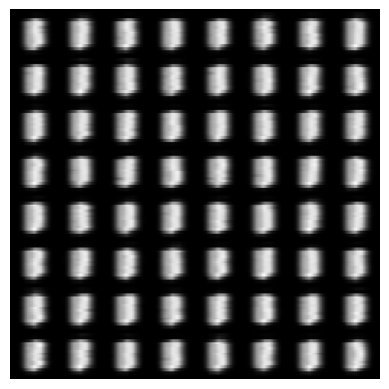

In [61]:
with torch.no_grad():  # ①
    sample_size = 64
    z = torch.randn(64, 64*12*28).to(device)  # ②[32, 64, 12, 28]
    z = z.view(sample_size, 64, 12, 28)
    x = model.decoder(z)  # ③
    generated_images = x.view(sample_size, 1, 28, 28)  # ④

# ⑤
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()